In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
from scale_aware_air_sea.utils import open_zarr
# from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.parameters import get_params
import numpy as np
import gcsfs
import matplotlib.pyplot as plt

In [3]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=16)
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41353 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/air_sea_project/proxy/41353/status,
Dashboard: /user/jbusecke/air_sea_project/proxy/41353/status,Workers: 1
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34741,Workers: 1
Dashboard: /user/jbusecke/air_sea_project/proxy/41353/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:37657,Total threads: 16
Dashboard: /user/jbusecke/air_sea_project/proxy/35919/status,Memory: 64.00 GiB
Nanny: tcp://127.0.0.1:32885,


In [15]:
# load global parameters
params = get_params('v0.7.0', test=False) 
primary_algo = 'ecmwf'
n_subsample = 4
subsample = dict(xt_ocean=slice(0, None, n_subsample), yt_ocean=slice(0,None, n_subsample))

fs = gcsfs.GCSFileSystem()
params['paths']['CM26']['filter_fluxes']
mapper_offline_flux = fs.get_mapper(params['paths']['CM26']['filter_fluxes'])
mapper_online_flux = fs.get_mapper('gs://cmip6/GFDL_CM2_6/control/ocean_boundary')
mapper_small_scale_flux = fs.get_mapper(params['paths']['CM26']['filter_decomposition_mean'])
mapper_ice_mask = fs.get_mapper(params['paths']['CM26']['ice_mask'])


ds_offline = open_zarr(mapper_offline_flux)
ds_online = open_zarr(mapper_online_flux)
ds_small_scale = open_zarr(mapper_small_scale_flux)
ds_ice = open_zarr(mapper_ice_mask)

## Mask out the online fluxes.
The small scale has already been masked. 
In the next iteration all the offline fluxes should be masked
- [ ] Remove the masking for all offline results

In [16]:
ds_online = ds_online.where(abs(ds_online.melt) == 0)
#
ds_offline = ds_offline.where(abs(ds_ice.melt.reset_coords(drop=True)) == 0)

# Appendix Plots

## difference between algos (both for full and small scale flux)

In this we can see that the small scale contribution is relatively similar between algos, whereas the absolute (full) flux differs quite a bit (this has been shown in the literature). 

In [17]:
roi = dict(time=slice('0181-01-01', '0181-02-01'))

In [24]:
ql_bins = np.linspace(-350, 10, 150)
qh_bins = np.linspace(-350, 50, 150)

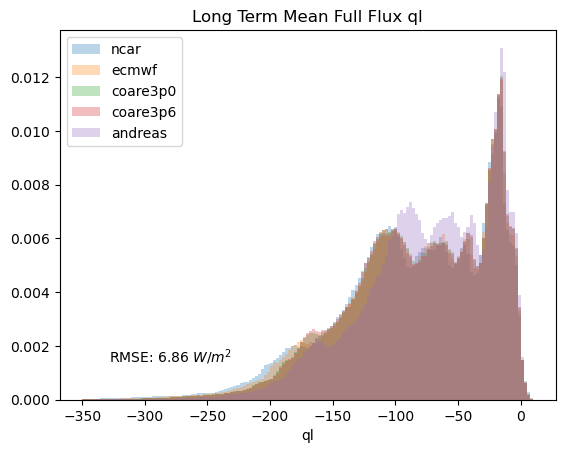

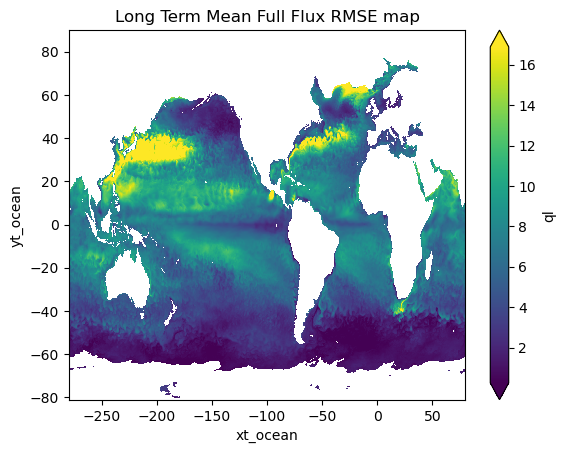

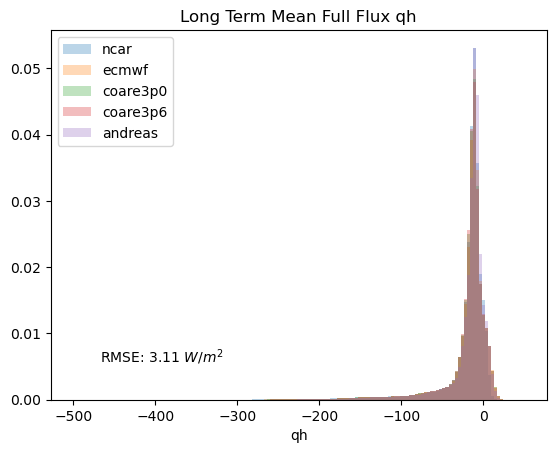

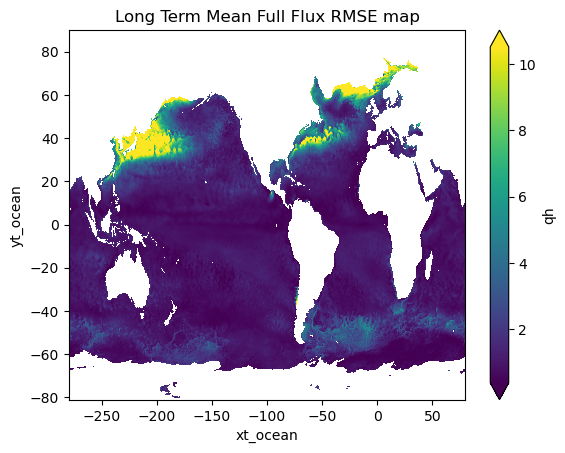

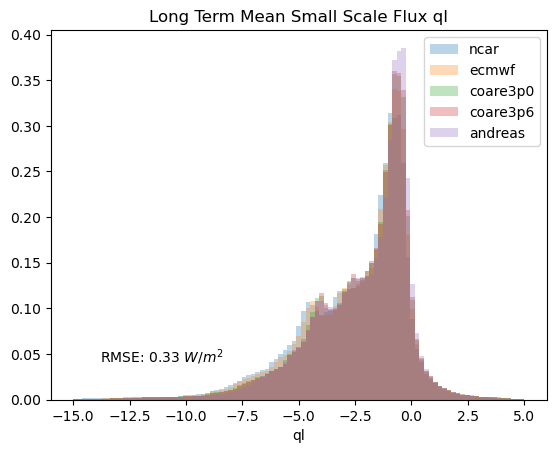

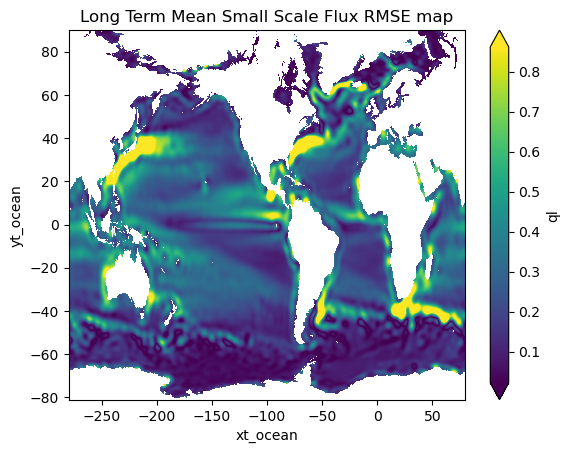

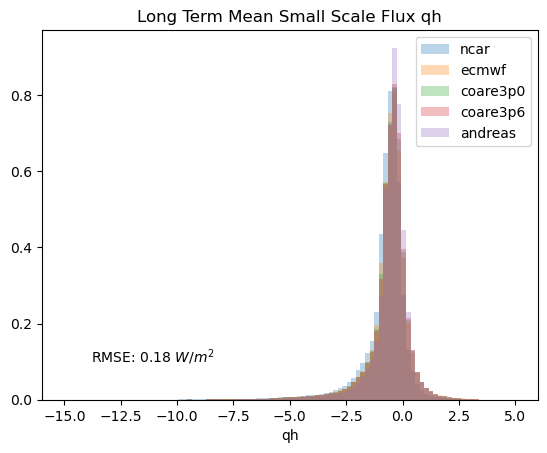

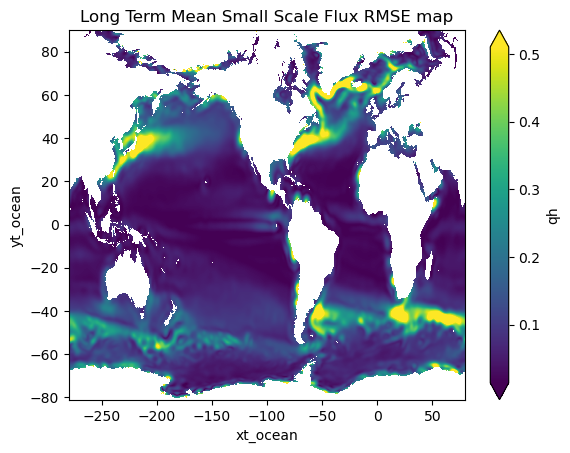

In [20]:
for input_ds, title in [
    (ds_offline.sel(smoothing='smooth_none').sel(**roi).mean('time'), 'Full Flux'), 
    (ds_small_scale.sel(term='Q_star_star'), 'Small Scale Flux')
]:
    for var, bins in [('ql',ql_bins), ('qh', qh_bins)]:
        fig, ax = plt.subplots()
        da_mean = input_ds[var].load()
        da_ref = da_mean.sel(algo=primary_algo) 
        da_diff = da_mean.drop_sel(algo='ecmwf') - da_ref
        if "Small Scale" in title:
            bins = np.linspace(-15, 5, 100)
        for algo in da_mean.algo:
            da_mean.sel(algo=algo).plot.hist(bins=bins,alpha=0.3, label=algo, density=True)

        rmse = (da_diff **2).mean(['algo', 'xt_ocean', 'yt_ocean']).pipe(np.sqrt)
        ax.text(0.1, 0.1, f"RMSE: {rmse.data:.2f} $W/m^2$", transform=ax.transAxes)
        ax.set_title(f'Long Term Mean {title} {var}')
        ax.legend()

        # show the RMSE for each location
        plt.figure()
        rmse_map = (da_diff **2).mean(['algo']).pipe(np.sqrt)
        rmse_map.plot(robust=True)
        plt.title(f'Long Term Mean {title} RMSE map')

## Compare long term online fluxes to our offline version

### TODO
- we need to deal with the sea ice!!!

<Figure size 640x480 with 0 Axes>

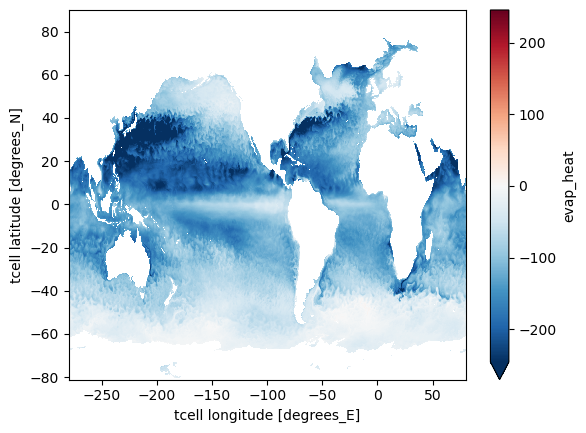

<Figure size 640x480 with 0 Axes>

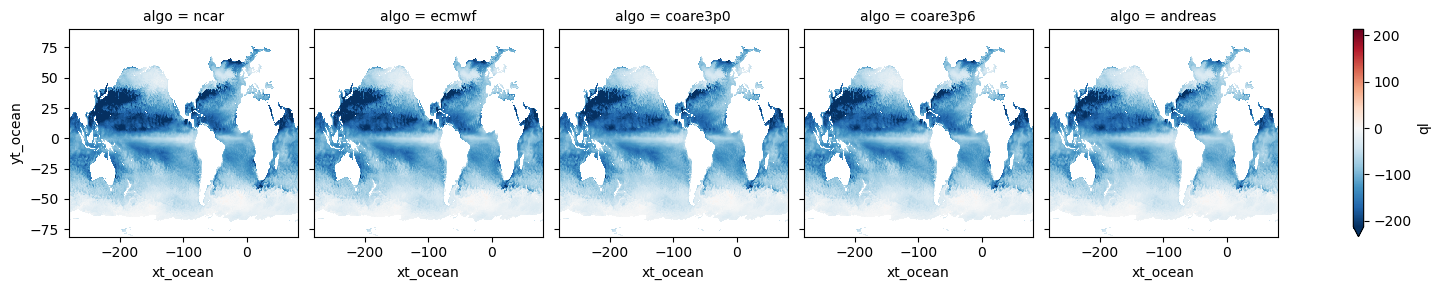

<Figure size 640x480 with 0 Axes>

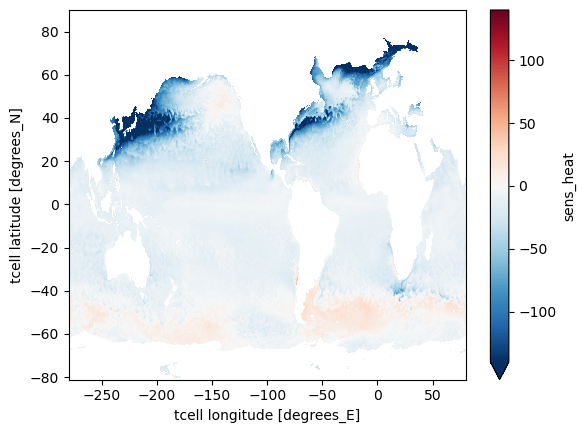

<Figure size 640x480 with 0 Axes>

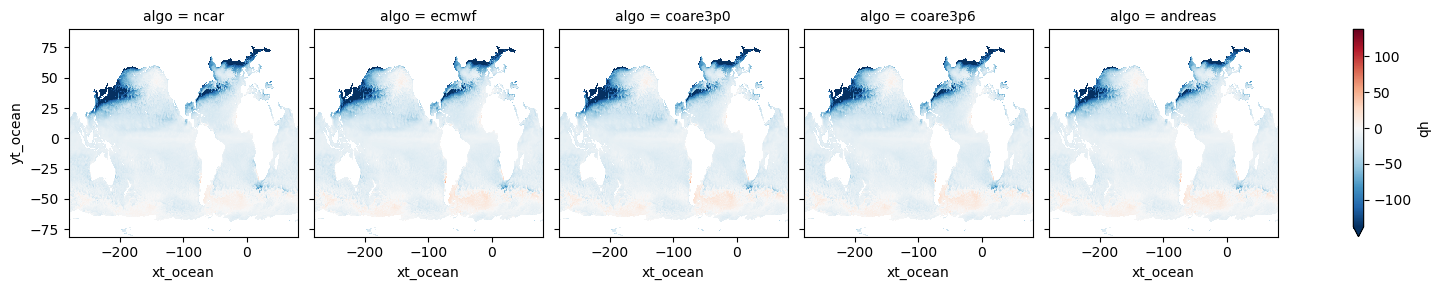

In [21]:
for online_var, offline_var in [('evap_heat', 'ql'), ('sens_heat', 'qh')]:
    plt.figure()
    da_online = ds_online[online_var].sel(**roi).mean('time').load()
    da_offline = ds_offline[offline_var].sel(smoothing='smooth_none').sel(**roi).mean('time').load()

    plot_kwargs = dict(robust=True, center=0) # where do we have positive ql?
    plt.figure()
    da_online.plot(**plot_kwargs)
    plt.figure()
    da_offline.isel(**subsample).plot(col='algo', **plot_kwargs)

<Figure size 640x480 with 0 Axes>

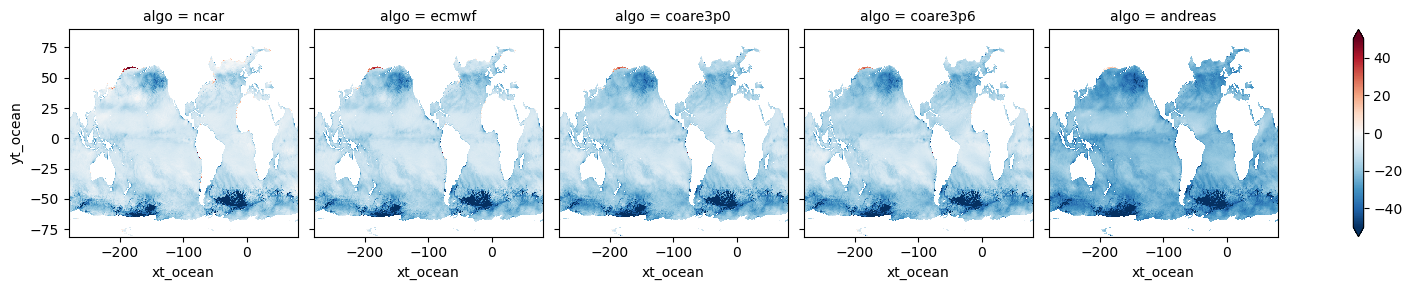

<Figure size 640x480 with 0 Axes>

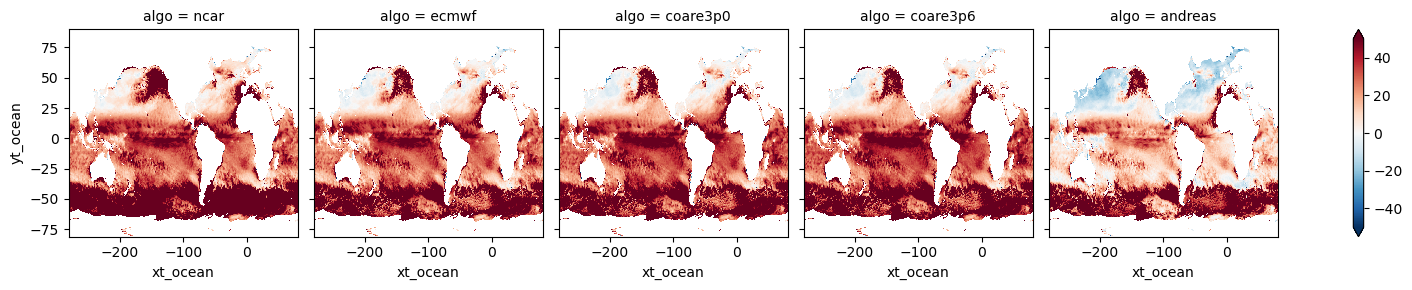

In [22]:
for online_var, offline_var in [('evap_heat', 'ql'), ('sens_heat', 'qh')]:
    plt.figure()
    da_online = ds_online[online_var].sel(**roi).mean('time').load()
    da_offline = ds_offline[offline_var].sel(smoothing='smooth_none').sel(**roi).mean('time').load()
    da_diff = ((da_online-da_offline)/abs(da_online)*100)
    da_diff.isel(**subsample).plot(col='algo', vmax=50)

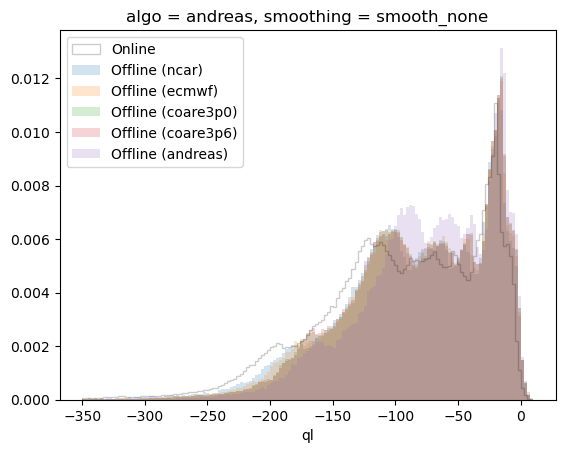

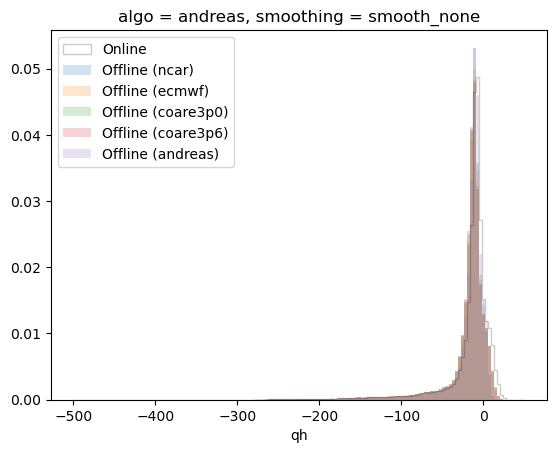

In [23]:
for online_var, offline_var, bins in [('evap_heat', 'ql', ql_bins), ('sens_heat', 'qh', qh_bins)]:
    fig, ax = plt.subplots()
    da_offline = ds_offline[offline_var].sel(smoothing='smooth_none').sel(**roi).mean('time').load()
    da_online = ds_online[online_var].sel(**roi).mean('time').load().where(~np.isnan(da_offline).all('algo'))
    
    plot_kwargs = dict(ax=ax, bins=bins, alpha=0.2, density=True)
    
    da_online.plot.hist(label='Online', **plot_kwargs, color='k', histtype='step')
    for algo in da_offline.algo:
        da_offline.sel(algo=algo).isel(**subsample).plot.hist(label=f'Offline ({algo.data})', **plot_kwargs)
        
    ax.legend()

Wait, there are positive latent heatfluxes? That seems wrong... I guess not?

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


<Figure size 640x480 with 0 Axes>

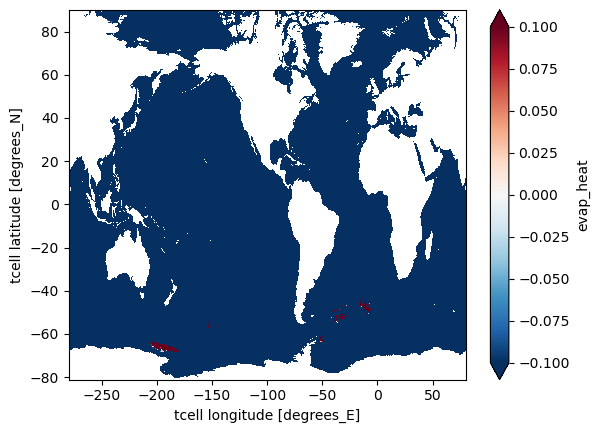

<Figure size 640x480 with 0 Axes>

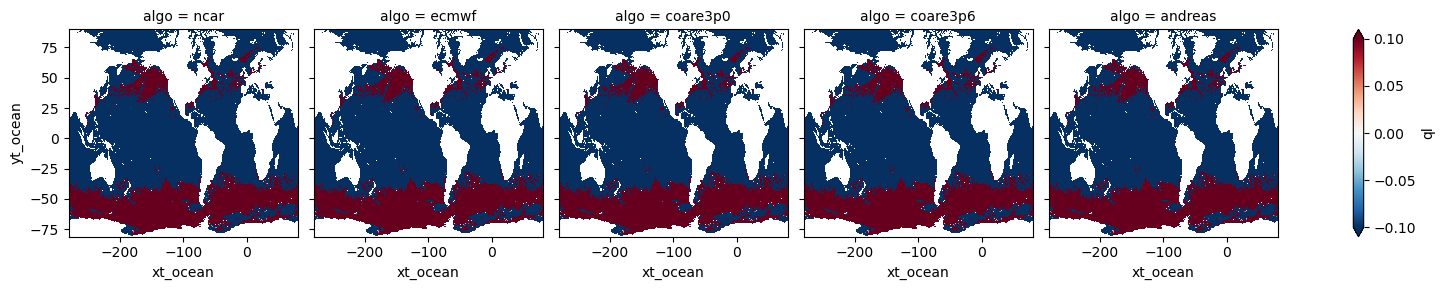

<Figure size 640x480 with 0 Axes>

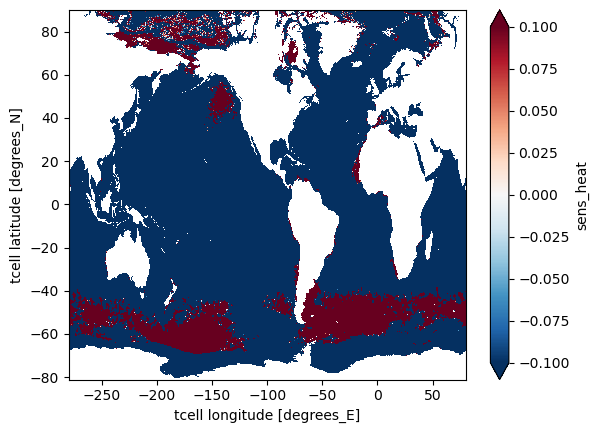

<Figure size 640x480 with 0 Axes>

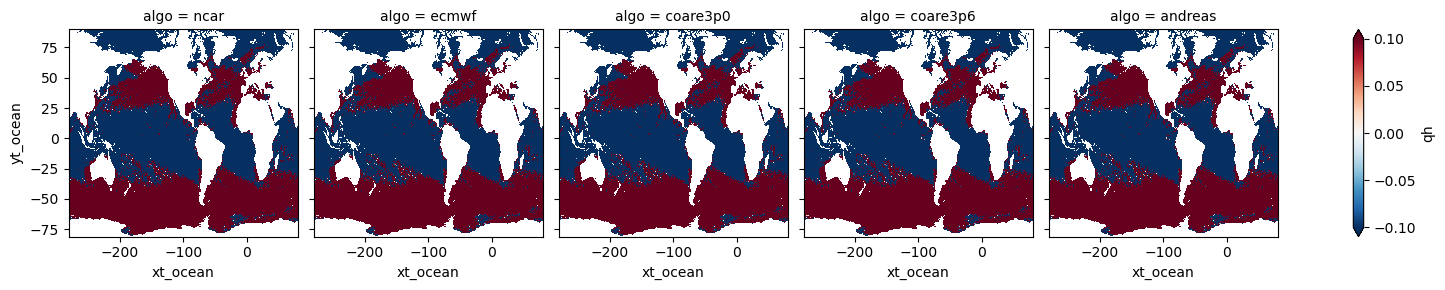

In [55]:
for online_var, offline_var in [('evap_heat', 'ql'), ('sens_heat', 'qh')]:
    plt.figure()
    da_online = ds_online[online_var].sel(**roi).max('time').load()
    da_offline = ds_offline[offline_var].sel(smoothing='smooth_none').sel(**roi).max('time').load()

    plot_kwargs = dict(vmax=0.1) # where do we have positive ql?
    plt.figure()
    da_online.plot(**plot_kwargs)
    plt.figure()
    da_offline.isel(**subsample).plot(col='algo', **plot_kwargs)